<a href="https://colab.research.google.com/github/ViduniFdo/Telco-Churn-Project/blob/main/TelcoChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [94]:
!pip install keras-tuner

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#keras for neural network
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

#Reproductibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)
tf.random.set_seed(random_state)

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Coursework/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

2.19.0


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Task 01: EDA

In [6]:
#CLEANING DATA

print(df.shape, "\n")
print(df.columns, "\n")
df.info()

df.describe(include='all')
df.duplicated().sum()

print(df.TotalCharges.dtypes)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
print(df.TotalCharges.dtypes)

print(df.TotalCharges.isnull().sum())
df.drop(index=df[df['TotalCharges'].isnull()].index, inplace=True)
print(df.TotalCharges.isnull().sum())
df.TotalCharges.head()

(7043, 21) 

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043

,TotalCharges
0,29.85
1,1889.50
2,108.15
3,1840.75
4,151.65


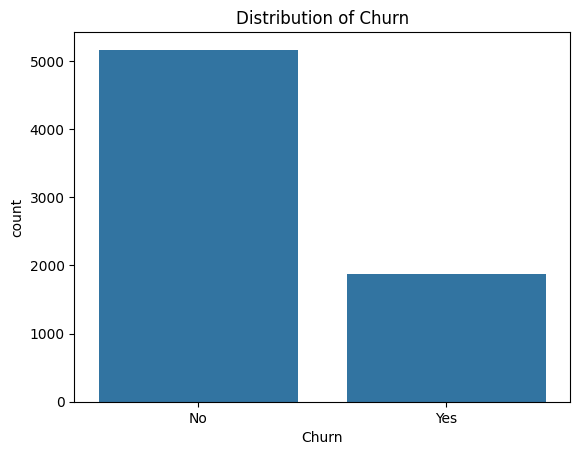

Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


In [9]:
#DESCRIPTIVE STATS

#churn distribution
sns.countplot(x="Churn", data=df)
plt.title("Distribution of Churn")
plt.show()
print(df['Churn'].value_counts(normalize=True)*100)

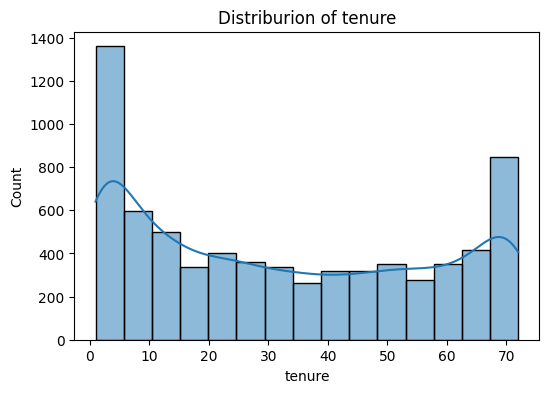

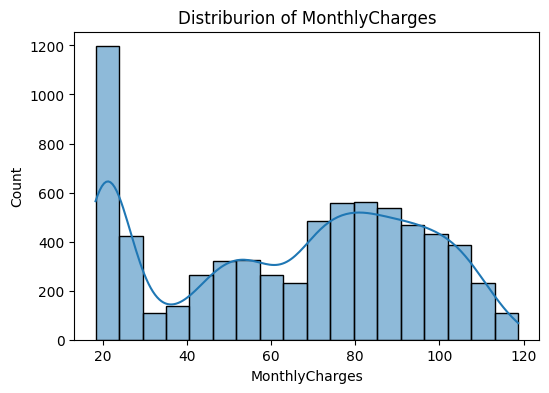

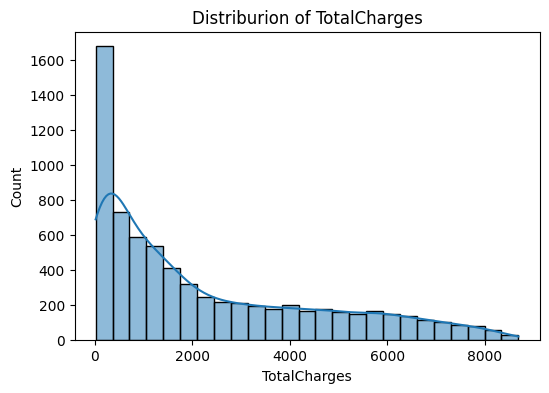

In [8]:
#UNIVARIATE ANALYSIS VISUALIZATION

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in numeric_cols:
  plt.figure(figsize=(6,4))
  sns.histplot(df[col], kde=True)
  plt.title(f'Distriburion of {col}')
  plt.show()


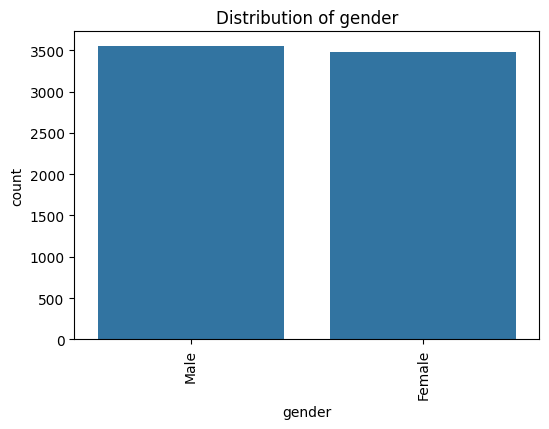

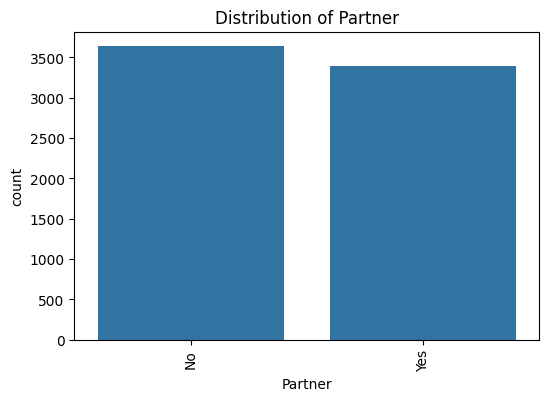

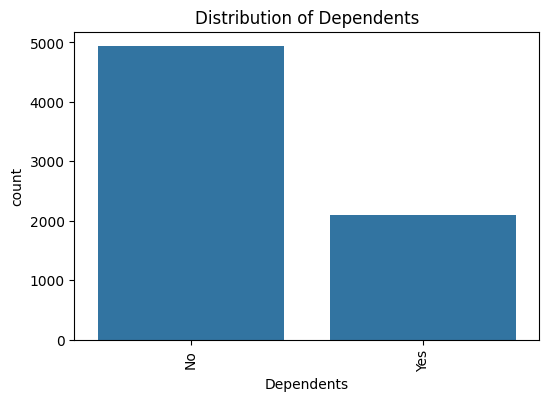

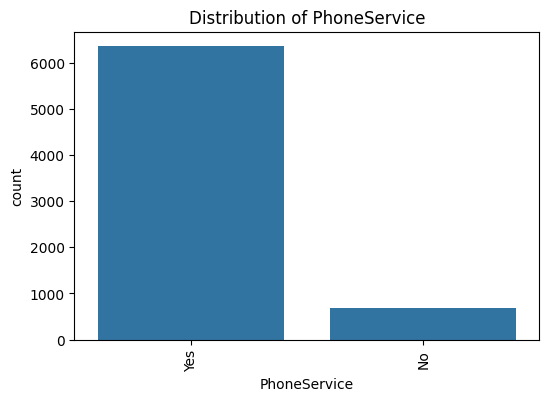

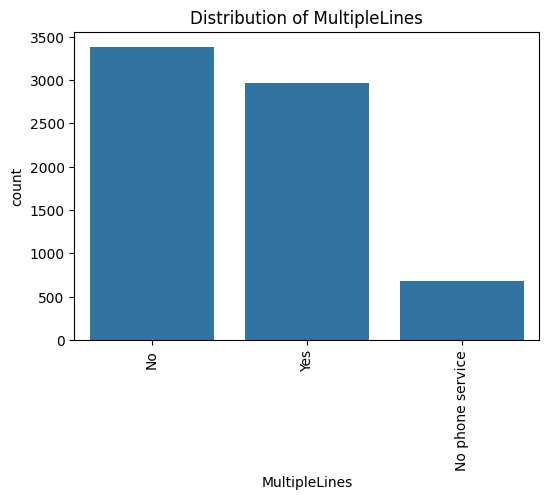

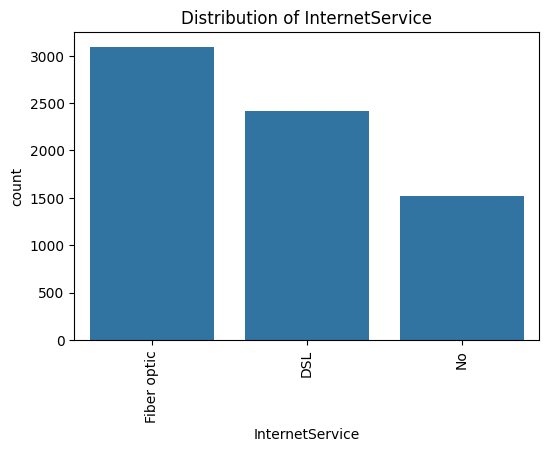

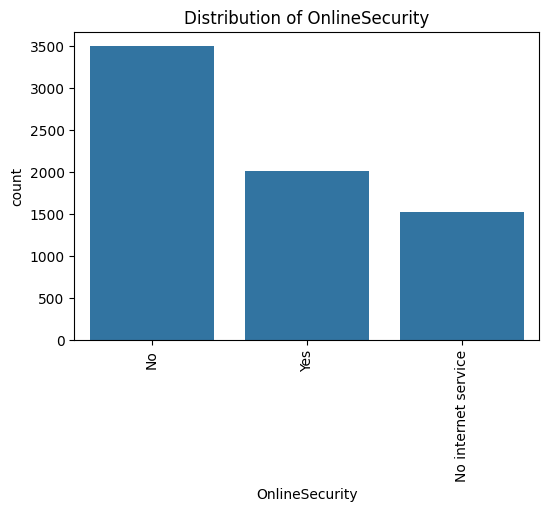

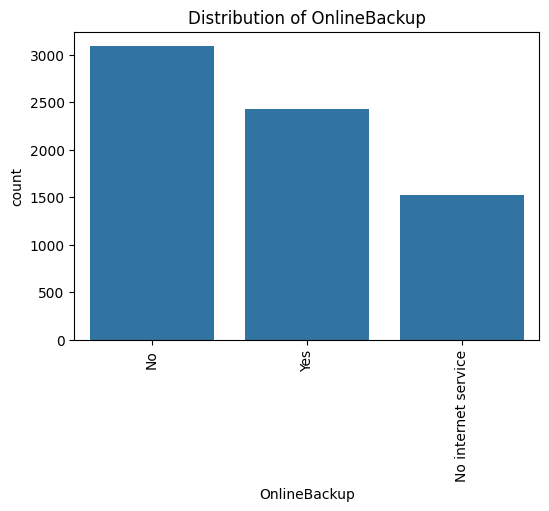

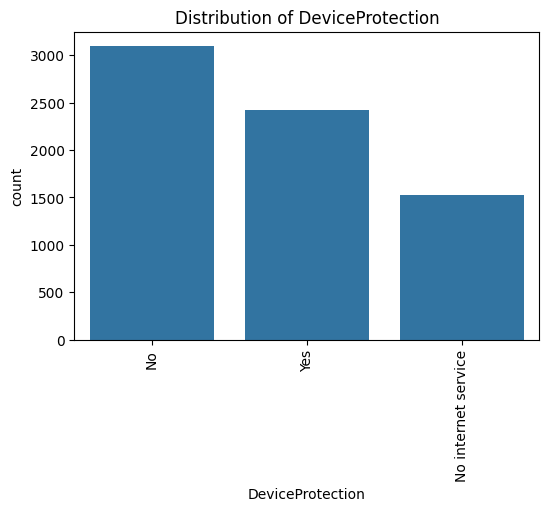

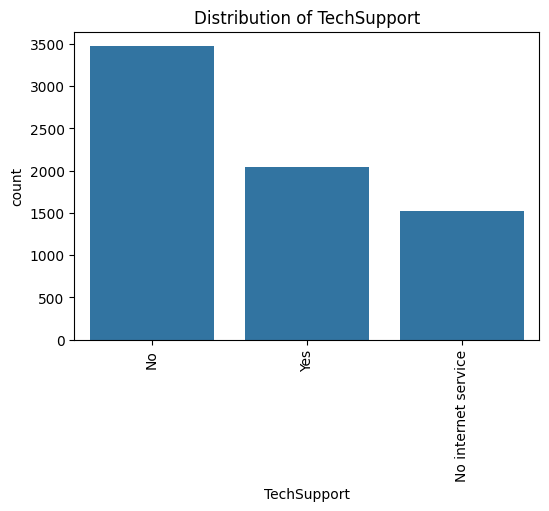

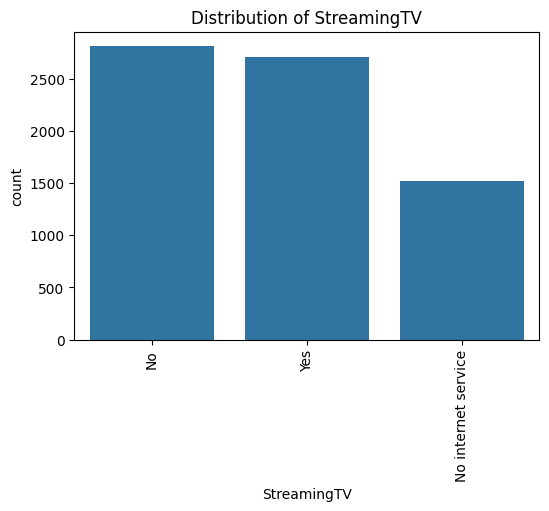

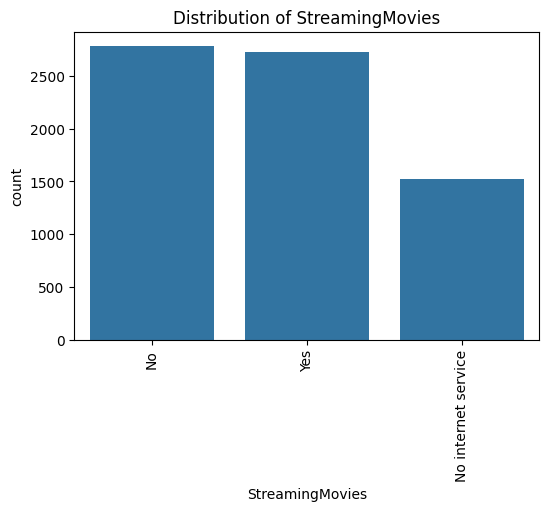

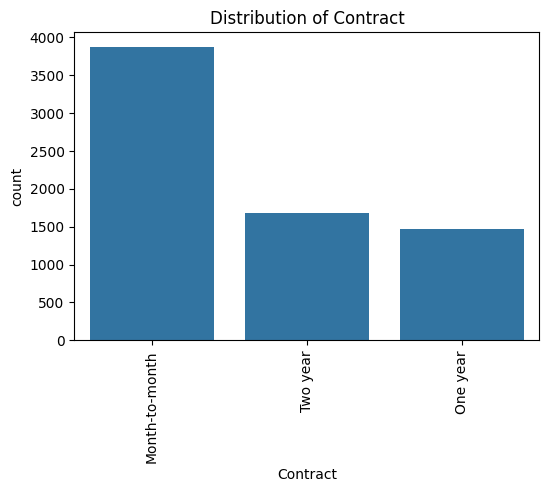

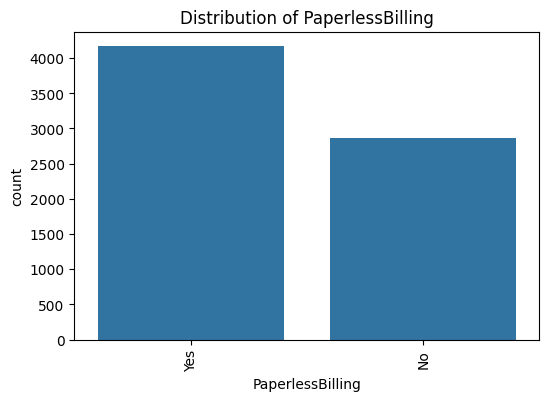

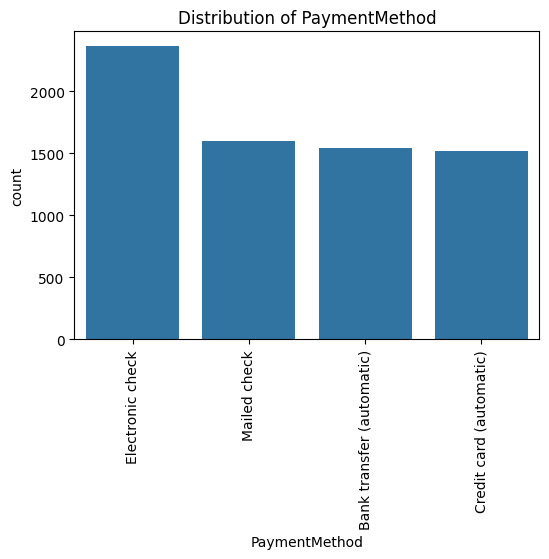

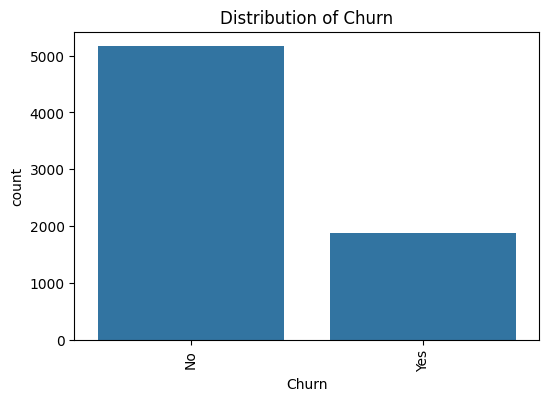

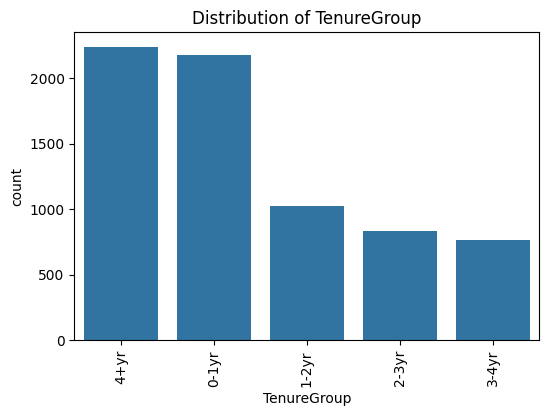

In [13]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols
for col in categorical_cols:
  plt.figure(figsize=(6,4))
  sns.countplot(x=col, data=df, order=df[col].value_counts().index)
  plt.title(f'Distribution of {col}')
  plt.xticks(rotation=90)
  plt.show()

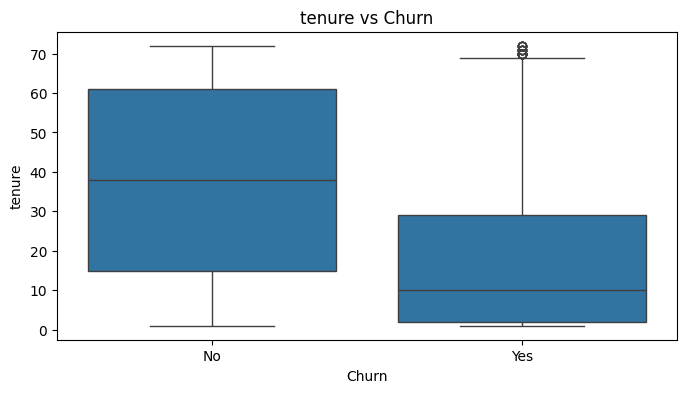

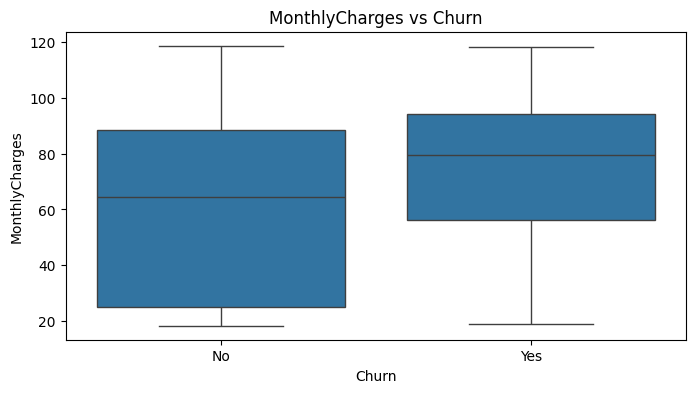

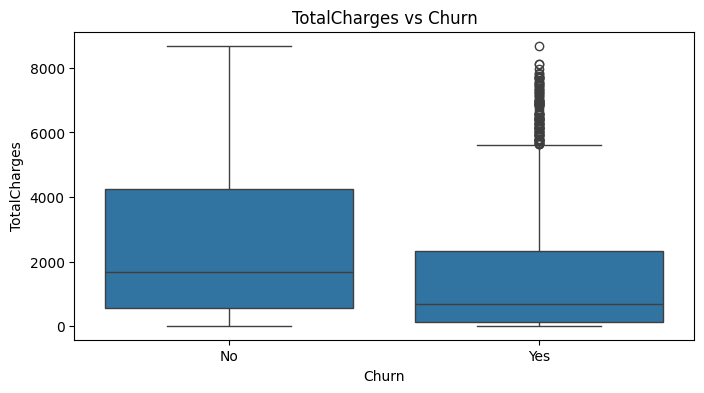

In [14]:
#BIVARIATE ANALYSIS VISUALIZATION

for col in numeric_cols:
  plt.figure(figsize=(8,4))
  sns.boxplot(x='Churn', y=col, data=df)
  plt.title(f'{col} vs Churn')
  plt.show()

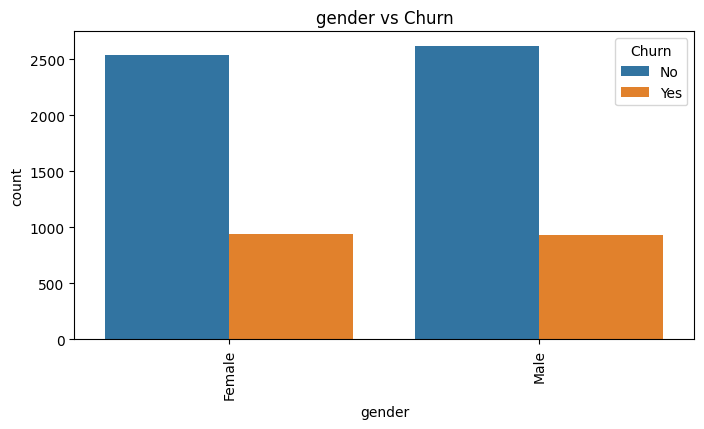

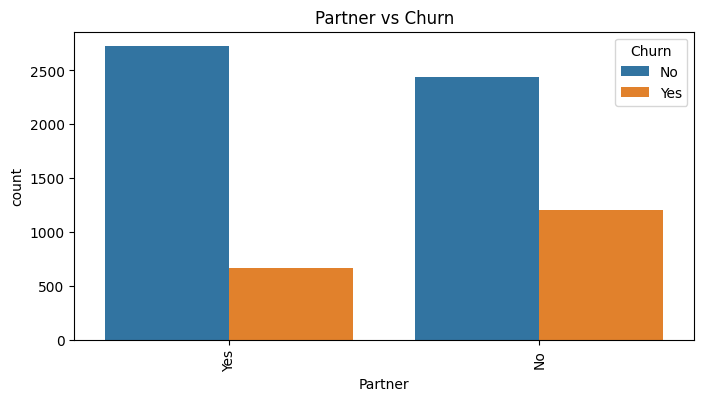

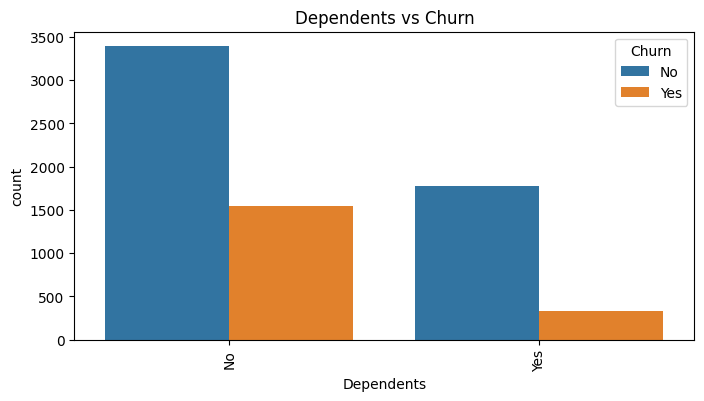

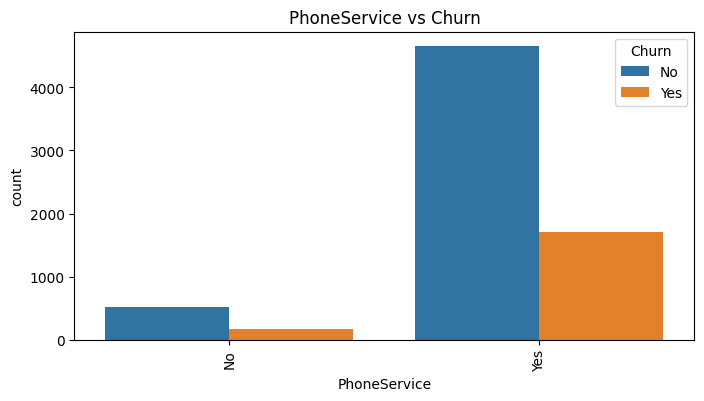

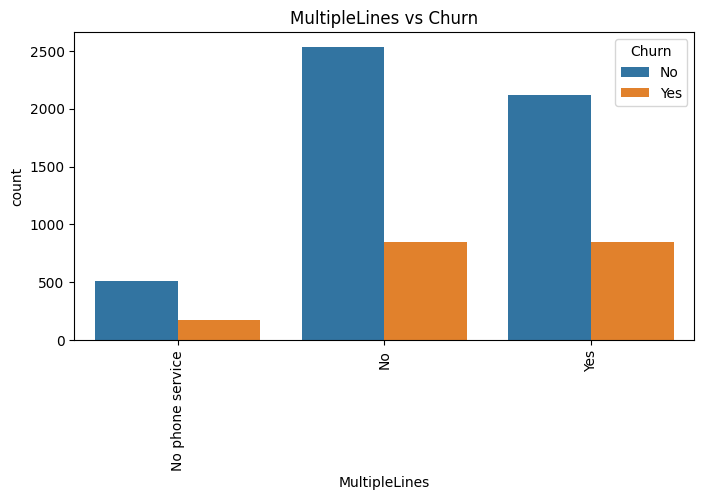

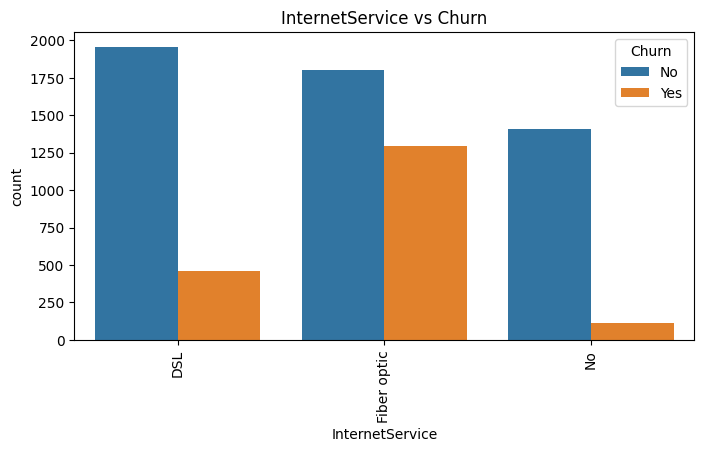

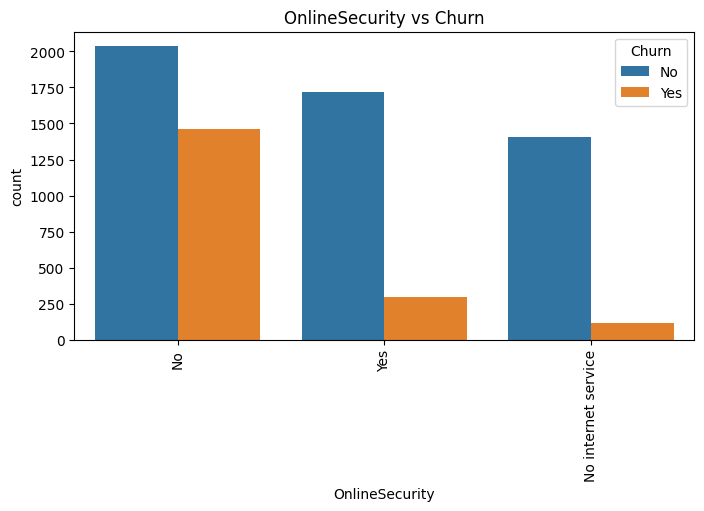

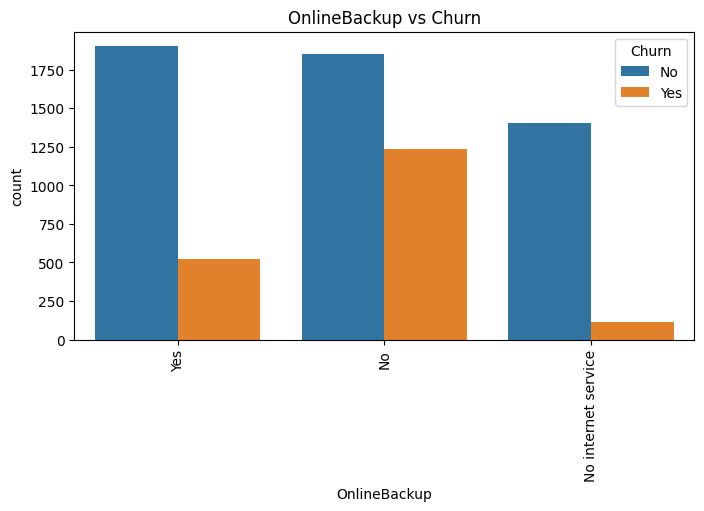

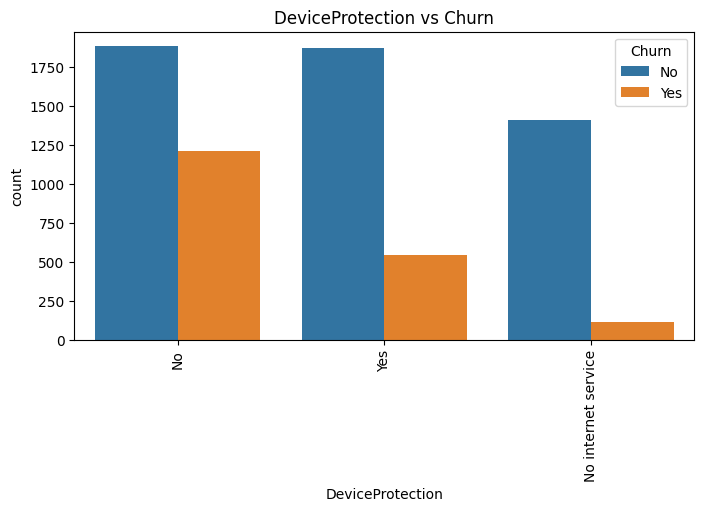

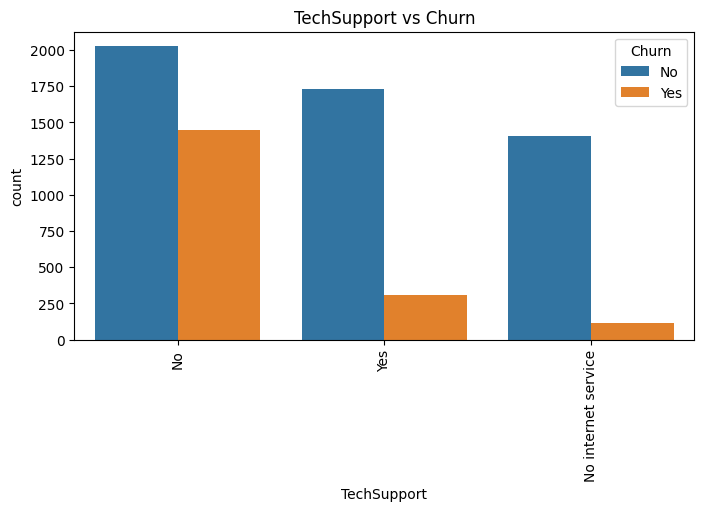

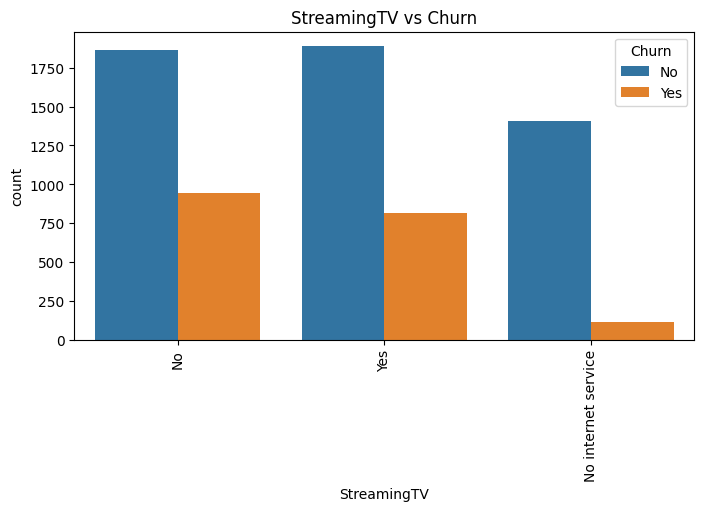

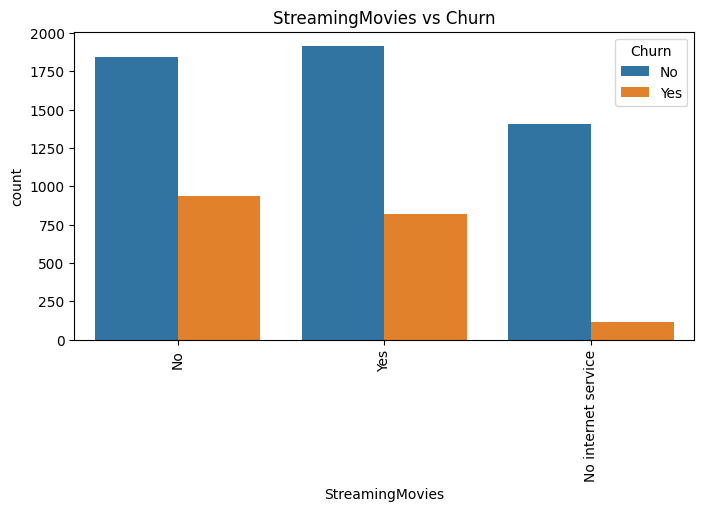

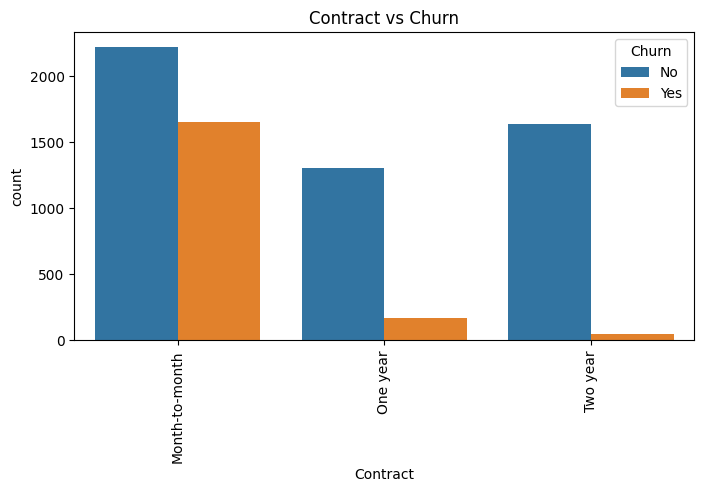

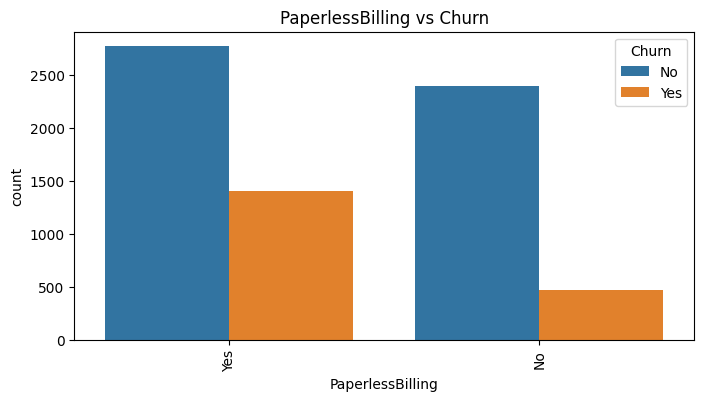

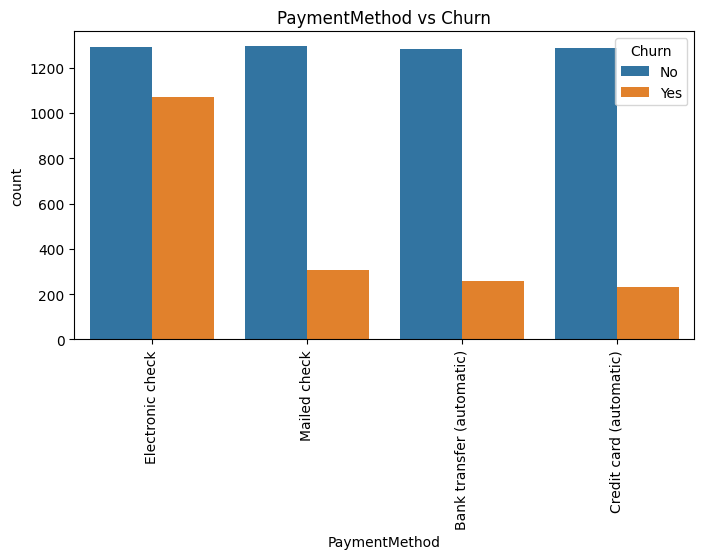

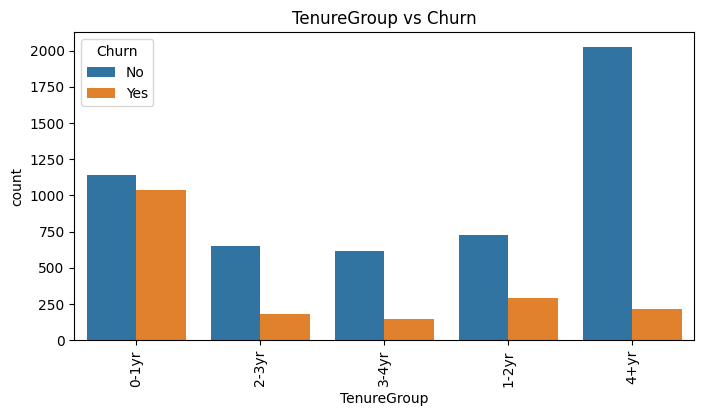

In [15]:
for col in categorical_cols:
  if col != 'Churn' and col != 'customerID':
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=90)
    plt.show()

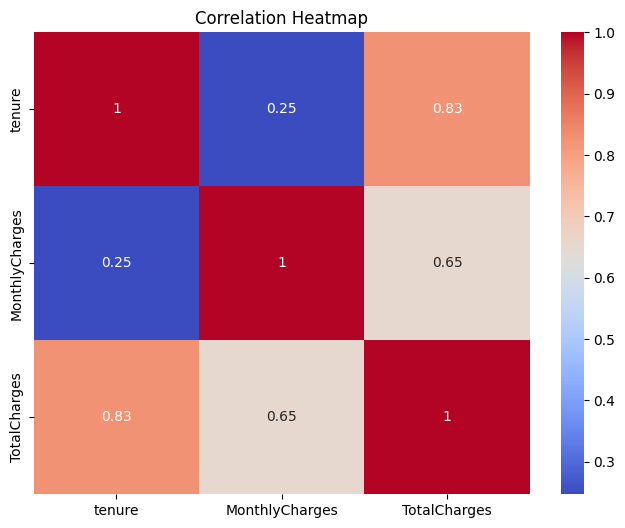

In [16]:
#correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Task 02

In [44]:
#DATA PREPROCESSING
df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')
categorical_cols.remove('customerID')

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

scalar = StandardScaler()
df_encoded[numeric_cols] = scalar.fit_transform(df_encoded[numeric_cols])

#FEATURE ENGINEERING

def tenure_grp(t):
  if t <= 12:
    return "0-1yr"
  elif t <= 24:
    return "1-2yr"
  elif t <= 36:
    return "2-3yr"
  elif t <= 48:
    return "3-4yr"
  else:
    return "4+yr"

df["TenureGroup"] = df["tenure"].apply(tenure_grp)
df['MonthlyTenure'] = df["MonthlyCharges"]*df["tenure"]

df_encoded['TenureGroup'] = df['TenureGroup']
df_encoded['MonthlyTenure'] = df['MonthlyTenure']
df_encoded = pd.get_dummies(df_encoded, columns=['TenureGroup'], drop_first=True)

In [37]:
#DATA SPLITTING

X = df_encoded.drop(['Churn', 'Churn_num'], axis=1)
y = df_encoded['Churn_num'].astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )

In [109]:
# DECISION TREE
dt = DecisionTreeClassifier(random_state = 42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 6, 7, 8],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf' : [5, 10, 15]
}

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_dt = grid_search.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("Decision Tree Model Results: ")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))


Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}
Decision Tree Model Results: 
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1033
           1       0.58      0.60      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407

[[872 161]
 [151 223]]
